## Tutorial - Influence Maximization in Boolean Networks - Biological Networks

In [1]:
#matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import basic modules
import time
import matplotlib.pyplot as plt

In [3]:
#copy CANA datasets into this directory if the package fails to install (package requires Microsoft Visual C++)
#import cana
from cana.boolean_node import *
from cana.boolean_network import *

In [4]:
#import scripts
from utils import *
from modules import *
from mean_field_computations import *
from brute_force_computations import *
from simulations import *
from entropy_computations import *
from driver_sets import *

#### Run mean-field approximation (IBMFA)

In [5]:
#read in the network
N=BooleanNetwork.from_file('drosophila_single_cell.txt',file_type='logical') #may be any file in logical form

In [6]:
#reduce the look-up-table and find all sunits (i.e. node states) in the network
dd={node.name: LUT_reduce(look_up_table(node)) for node in N.nodes}
nodes=dd.keys()
print len(dd),nodes
modules,translator={},{}
sunits,sunit_map=get_sunits(N)
print len(sunits),sunit_map

17 ['wg', 'WG', 'nhhnHH', 'en', 'ptc', 'ci', 'SLP', 'HH', 'CI', 'SMO', 'CIR', 'hh', 'nWG', 'EN', 'PH', 'PTC', 'CIA']
34 {0: 'SLP-0', 1: 'SLP-1', 2: 'nWG-0', 3: 'nWG-1', 4: 'nhhnHH-0', 5: 'nhhnHH-1', 6: 'wg-0', 7: 'wg-1', 8: 'WG-0', 9: 'WG-1', 10: 'en-0', 11: 'en-1', 12: 'EN-0', 13: 'EN-1', 14: 'hh-0', 15: 'hh-1', 16: 'HH-0', 17: 'HH-1', 18: 'ptc-0', 19: 'ptc-1', 20: 'PTC-0', 21: 'PTC-1', 22: 'PH-0', 23: 'PH-1', 24: 'SMO-0', 25: 'SMO-1', 26: 'ci-0', 27: 'ci-1', 28: 'CI-0', 29: 'CI-1', 30: 'CIA-0', 31: 'CIA-1', 32: 'CIR-0', 33: 'CIR-1'}


In [7]:
#use the IBMFA to find influence pathways for all possible seeds (see code for explanation of various parameters)
seed_size=1 #size of each seed set
iterations=10 #how long to run the IBMFA for
start_time = time.time()
modules,translator=find_modules(N,seed_size,sunits,sunit_map,modules,translator,reduced=True,ds=dd,
                pinning={},iterations=iterations,data=True,pin_start=True,update='synchronous',regenerate=False,models=1)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

seeds: 34
--- Total time: 3.98000001907 seconds ---


In [8]:
#visualize final time step of a seed
seed=['en-1'] #labeled as [name of node1-state of node1, name of node2-state of node2, etc], e.g. ['en-1','SLP-0']
seed=str(tuple(sorted([reverse_sunit_map(sunit_map)[x] for x in seed]))) #internal label used by the code, e.g. '(11,)'
print(seed,modules[seed][iterations])

('(11,)', {'wg': 0.0046480316668748856, 'WG': 0.009296063333749771, 'nhhnHH': 0.5, 'en': 1.0, 'ptc': 0.0, 'ci': 0.0, 'SLP': 0.5, 'HH': 1.0, 'CI': 0.0, 'SMO': 0.998443603515625, 'CIR': 0.0, 'hh': 1.0, 'nWG': 0.5, 'EN': 1.0, 'PH': 0.001556396484375, 'PTC': 0.001556396484375, 'CIA': 0.0})


In [9]:
#check accuracy by comparing to simulations; NOTE: recall/precision based on constant predictions (i.e. s=0 or s=1)
seeds=modules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
iterations=10
length=1 #seed set size
runs=100 #number of simulations per seed set
start_time = time.time()
simulations=compare_simulations(N,seeds,sunit_map,modules,translator,length=length,runs=runs,tau=0.0,
                iterations=iterations,unknown_prob=0.5,stats={},results=True,time_limit=iterations+2)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

total seeds: 34
true positives: [1.0, 1.0, 0.99, 0.97, 0.96, 0.93, 0.93, 0.92, 0.91, 0.9, 0.9]
false negatives: [0.0, 0.0, 0.01, 0.03, 0.04, 0.07, 0.07, 0.08, 0.09, 0.1, 0.1]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 1.0, 1.0, 0.99, 0.99, 0.98, 0.98, 0.98, 0.98, 0.97, 0.97]
recall: [1.0, 1.0, 0.99, 0.97, 0.96, 0.93, 0.93, 0.92, 0.91, 0.9, 0.9]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 1.0, 0.97, 0.88, 0.82, 0.74, 0.71, 0.65, 0.62, 0.62, 0.62]
errors: [0.002, 0.002, 0.002, 0.008, 0.012, 0.014, 0.014, 0.016, 0.016, 0.016, 0.017]
--- Total time: 3.49000000954 seconds ---


In [10]:
#aggregate simulations; can also use create_simulations as a shortcut if above results aren't needed
length=1
#simulations,act_prob_sim=create_simulations(N,seeds,sunit_map,translator,length=length,runs=100,iterations=10,
#                  unknown_prob=0.5,time_limit=12,act_prob_sim={},update='synchronous',order=None,regenerate=False)
act_prob_sim={}
for seed in seeds: aggregate_simulation(seed,simulations,act_prob_sim)
print(seed,act_prob_sim[seed][iterations])

('(6,)', {'wg': 0.0, 'WG': 0.0, 'nhhnHH': 0.54, 'en': 0.28, 'ptc': 0.38, 'SLP': 0.47, 'ci': 0.72, 'CI': 0.72, 'SMO': 0.55, 'CIR': 0.34, 'HH': 0.28, 'nWG': 0.48, 'EN': 0.28, 'PH': 0.38, 'hh': 0.28, 'PTC': 0.83, 'CIA': 0.38})


In [11]:
#compare errors to a variance baseline
stats=compare_baseline(N,seeds,sunit_map,translator,simulations,length=length,tau=0.0,iterations=10,stats={},results=True)

total seeds: 34
true positives: [0.53, 0.63, 0.67, 0.67, 0.66, 0.66, 0.65, 0.65, 0.64, 0.64, 0.64]
false negatives: [0.47, 0.37, 0.33, 0.33, 0.34, 0.34, 0.35, 0.35, 0.36, 0.36, 0.36]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [0.53, 0.63, 0.67, 0.67, 0.66, 0.66, 0.65, 0.65, 0.64, 0.64, 0.64]
recall: [0.53, 0.63, 0.67, 0.67, 0.66, 0.66, 0.65, 0.65, 0.64, 0.64, 0.64]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errors: [0.471, 0.372, 0.329, 0.334, 0.336, 0.344, 0.349, 0.353, 0.358, 0.357, 0.357]


In [12]:
#find entropy of seeds
seed='(11,)' #en-1
diffusion=modules[seed] #may select modules or act_prob_sim
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
print(to_list(seed,sunit_map,translator),seed_entropy)

(['en-1'], {0: 0.9411764705882353, 1: 0.7788887876520972, 2: 0.666364999152068, 3: 0.555442201278125, 4: 0.42363419333759167, 5: 0.34172400465685665, 6: 0.26430133345245066, 7: 0.22947989569965307, 8: 0.20743569986544752, 9: 0.1941628270095066, 10: 0.18641653786297874})


In [13]:
#find all node entropies based on IBMFA and based on simulations
seed_entropy,seed_configs=seed_entropies(modules,seeds,normalized=True,data=False)
seed_entropy_sim,seed_configs_sim=seed_entropies(act_prob_sim,seeds,normalized=True,data=False)
len(seed_entropy),len(seed_entropy_sim)

(34, 34)

Lowest: (11,) [0.94, 0.78, 0.67, 0.56, 0.42, 0.34, 0.26, 0.23, 0.21, 0.19, 0.19] ['en-1']
Highest: (32,) [0.94, 0.89, 0.88, 0.86, 0.82, 0.83, 0.84, 0.84, 0.85, 0.86, 0.86] ['CIR-0']


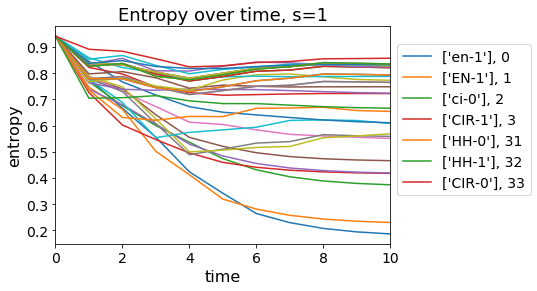

In [14]:
#graph predicted entropy over time
iterations,length=11,1
t=10 #iteration at which to compare seeds in order to sort them
sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][t])
print 'Lowest:',sorted_entropies[0],[round(seed_entropy[sorted_entropies[0]][t],2) for t in seed_entropy[sorted_entropies[0]]],
print to_list(sorted_entropies[0],sunit_map,translator)
print 'Highest:',sorted_entropies[-1],[round(seed_entropy[sorted_entropies[-1]][t],2) for t in seed_entropy[sorted_entropies[-1]]],
print to_list(sorted_entropies[-1],sunit_map,translator)
xvalues=range(iterations)
for index,seed in enumerate(sorted_entropies):
    if index<4 or index>30:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues],label=str(to_list(seed,sunit_map,translator))+', '+str(index))
    else:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues])
plt.title("Entropy over time, s="+str(length),fontsize=18)
plt.ylabel("entropy",fontsize=16)
plt.xlabel("time",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,iterations-1])
plt.legend(bbox_to_anchor=(1.0, 0.95),fontsize=14)

In [15]:
#find minimum driver set to reach zero entropy (attractor 4 for drosophila SPN)
#NOTE: can use top_selection to retrieve selection and entropies, or driver_selection to retrieve reduced driver set in one step
start_time = time.time()
selections,entropies=top_selection(N,sunits,sunit_map,modules,translator,seeds=None,max_s=10,top=1,reduced=True,ds=dd,
        iterations=10,attractor=None,attractors=None,force=False,pin_start=True,update='synchronous',regenerate=False)
for seed in selections: print(seed, entropies[seed], to_list(seed,sunit_map,translator))
print(reduce_selection(seed,N,sunits,sunit_map,modules,translator,reduced=True,ds=dd,t=10)) #reduce the final selection
#selection=driver_selection(N,sunits,sunit_map,modules,translator,attractor=None,attractors=None,
#                               update='synchronous',order=None,regenerate=False)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

('()', 0.8778820413116638, [])
('(11,)', 0.18641653786297874, ['en-1'])
('(0, 11)', 0.12060489322658603, ['SLP-0', 'en-1'])
('(0, 5, 11)', 0.058823529411764705, ['SLP-0', 'nhhnHH-1', 'en-1'])
('(0, 3, 5, 11)', 0.0, ['SLP-0', 'nWG-1', 'nhhnHH-1', 'en-1'])
('(0, 3, 5, 11, 26)', 0.0, ['SLP-0', 'nWG-1', 'nhhnHH-1', 'en-1', 'ci-0'])
('(0, 3, 5, 11, 26)', 0.0, ['SLP-0', 'nWG-1', 'nhhnHH-1', 'en-1', 'ci-0'])
('(0, 3, 5, 11, 26)', 0.0, ['SLP-0', 'nWG-1', 'nhhnHH-1', 'en-1', 'ci-0'])
('(0, 3, 5, 11, 26)', 0.0, ['SLP-0', 'nWG-1', 'nhhnHH-1', 'en-1', 'ci-0'])
('(0, 3, 5, 11, 26)', 0.0, ['SLP-0', 'nWG-1', 'nhhnHH-1', 'en-1', 'ci-0'])
('(0, 3, 5, 11, 26)', 0.0, ['SLP-0', 'nWG-1', 'nhhnHH-1', 'en-1', 'ci-0'])
(0, 3, 5)
--- Total time: 15.5130000114 seconds ---


In [16]:
#determine actual entropy of driver set based on simulations
entropies_sim=strategy_entropy(selections,N,sunit_map,modules,translator,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,
                stats={},results=False,time_limit=12,act_prob_sim=act_prob_sim,entropies_sim={},t=10)
for seed in sorted(entropies_sim,key=lambda x: len(x)): 
    print(seed),
    print(entropies_sim[seed])

() 0.870673005349497
(11,) 0.3965560026068499
(0, 11) 0.22695812014705266
(0, 5, 11) 0.05808974765327707
(0, 3, 5, 11) 0.0
(0, 3, 5, 11, 26) 0.0


In [17]:
#compare to a randomized selection; NOTE: sampling may take a while to run
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try
selections_ls,avg=avg_random_selections(N,sunits,sunit_map,modules,translator,samples=samples,seeds=None,max_s=10,
        reduced=True,ds=dd,t=10,runs=runs,stats={},act_prob_sim=act_prob_sim,entropies_sim=entropies_sim,attractor=None)
print(avg,len(selections_ls))

({0: 0.870673005349498, 1: 0.7176434883699817, 2: 0.5890844134036703, 3: 0.48085822821619884, 4: 0.3984294669901169, 5: 0.3263413610118382, 6: 0.2807445978760638, 7: 0.22986105328557815, 8: 0.18767464636945758, 9: 0.14922375555394493, 10: 0.12305067905514452}, 100)


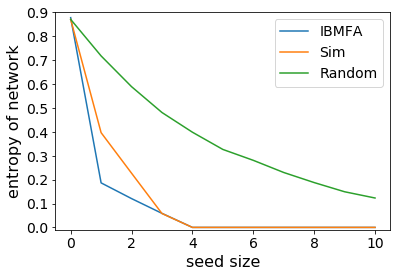

In [18]:
#visualize reduction of entropy (normalized)
iterations=10
xvalues=range(iterations+1)
plt.plot(xvalues,[entropies[seed] for seed in selections],label='IBMFA')
plt.plot(xvalues,[entropies_sim[seed] for seed in selections],label='Sim')
plt.plot(xvalues,[avg[x] for x in xvalues],label='Random')
plt.ylabel("entropy of network",fontsize=16)
plt.xlabel("seed size",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(np.arange(0,1,.1),fontsize=14)
plt.ylim([-.01,0.9])
plt.legend(fontsize=14)

In [19]:
#find attractors
attractors=attractors_to_dict(N)
print(attractors.keys())

['11111000011111110', '01000111100010000', '00000000001001101', '00111000011111110', '00100000011111110', '10111000011111110', '01100111100010000', '10000000001001101', '11000000001001101', '01000111101000000']


In [20]:
#find driver set for all attractors
iterations=10 #how long to run the IBMFA
t=iterations #at which iteration to compare entropy when making selections
drivers={}
for i,attractor in enumerate(attractors):
    selection=driver_selection(N,sunits,sunit_map,modules,translator,attractor=attractor,attractors=attractors,
                iterations=iterations,t=t,update='synchronous',order=None,regenerate=False)
    drivers[i]=selection
    print(i,attractor)
    print(selection,to_list(selection,sunit_map))

(0, '11111000011111110')
((1, 3, 5), ['SLP-1', 'nWG-1', 'nhhnHH-1'])
(1, '01000111100010000')
((0, 3, 4, 20), ['SLP-0', 'nWG-1', 'nhhnHH-0', 'PTC-0'])
(2, '00000000001001101')
((0, 2, 4, 21), ['SLP-0', 'nWG-0', 'nhhnHH-0', 'PTC-1'])
(3, '00111000011111110')
((0, 2, 5, 7), ['SLP-0', 'nWG-0', 'nhhnHH-1', 'wg-1'])
(4, '00100000011111110')
((0, 2, 5, 6), ['SLP-0', 'nWG-0', 'nhhnHH-1', 'wg-0'])
(5, '10111000011111110')
((1, 2, 5), ['SLP-1', 'nWG-0', 'nhhnHH-1'])
(6, '01100111100010000')
((0, 3, 5), ['SLP-0', 'nWG-1', 'nhhnHH-1'])
(7, '10000000001001101')
((1, 2, 4, 21), ['SLP-1', 'nWG-0', 'nhhnHH-0', 'PTC-1'])
(8, '11000000001001101')
((1, 3, 4, 21), ['SLP-1', 'nWG-1', 'nhhnHH-0', 'PTC-1'])
(9, '01000111101000000')
((0, 3, 4, 21), ['SLP-0', 'nWG-1', 'nhhnHH-0', 'PTC-1'])


In [21]:
#check that our solutions are in fact drivers
bf_drivers={}
solutions=[drivers[x] for x in drivers]
for solution in solutions:
    fixed_points=find_attractors_bruteforce(N,None,sunits,sunit_map,solution,{},time_limit=15)
    print solution,len(fixed_points)
    for x in fixed_points:
        for i,a in enumerate(attractors):
            if x==attractors[a]:
                print "Attractor found:",i+1,a,[fixed_points[x] for x in fixed_points]
                if len(fixed_points)==1: #we found a unique solution
                    bf_drivers[i]=solution

(1, 3, 5) 1
Attractor found: 1 11111000011111110 [16384]
(0, 3, 4, 20) 1
Attractor found: 2 01000111100010000 [8192]
(0, 2, 4, 21) 1
Attractor found: 3 00000000001001101 [8192]
(0, 2, 5, 7) 1
Attractor found: 4 00111000011111110 [8192]
(0, 2, 5, 6) 1
Attractor found: 5 00100000011111110 [8192]
(1, 2, 5) 1
Attractor found: 6 10111000011111110 [16384]
(0, 3, 5) 1
Attractor found: 7 01100111100010000 [16384]
(1, 2, 4, 21) 1
Attractor found: 8 10000000001001101 [8192]
(1, 3, 4, 21) 1
Attractor found: 9 11000000001001101 [8192]
(0, 3, 4, 21) 1
Attractor found: 10 01000111101000000 [8192]


In [22]:
#calculate brute-force answers by looking for smaller solutions
#NOTE: solutions must be at least 3 because there are 3 input nodes for the drosophila SPN
seeds=combinations(sunit_map.keys(),3)
for seed in seeds:
    seed=[s for s in sorted(list(seed))]
    #quick check for contradiction
    vals=[sunit_map[x][:-2] for x in seed]
    if len(set(vals))<len(vals): #we have multiple nodes sharing the same variable
        continue
    if not 'SLP' in vals or not 'nhhnHH' in vals or not 'nWG' in vals: continue #solution must contain the input nodes
    print seed,vals
    fixed_points=find_attractors_bruteforce(N,None,sunits,sunit_map,seed,{},time_limit=12)
    print {len(x) for x in fixed_points},len(fixed_points),[fixed_points[x] for x in fixed_points]
    for x in fixed_points:
        for i,a in enumerate(attractors):
            if x==attractors[a]:
                print "Attractor found:",i+1,a,fixed_points[x]
                if len(fixed_points)==1: #we found a unique solution so overwrite our previous one
                    bf_drivers[i]=tuple(seed) #update bf_drivers

[0, 2, 4] ['SLP', 'nWG', 'nhhnHH']
set([17]) 1 [16384]
Attractor found: 3 00000000001001101 16384
[0, 2, 5] ['SLP', 'nWG', 'nhhnHH']
set([17]) 2 [16256, 128]
Attractor found: 5 00100000011111110 16256
Attractor found: 4 00111000011111110 128
[0, 3, 4] ['SLP', 'nWG', 'nhhnHH']
set([17]) 2 [2688, 13696]
Attractor found: 2 01000111100010000 2688
Attractor found: 10 01000111101000000 13696
[0, 3, 5] ['SLP', 'nWG', 'nhhnHH']
set([17]) 1 [16384]
Attractor found: 7 01100111100010000 16384
[1, 2, 4] ['SLP', 'nWG', 'nhhnHH']
set([17]) 1 [16384]
Attractor found: 8 10000000001001101 16384
[1, 2, 5] ['SLP', 'nWG', 'nhhnHH']
set([17]) 1 [16384]
Attractor found: 6 10111000011111110 16384
[1, 3, 4] ['SLP', 'nWG', 'nhhnHH']
set([17]) 1 [16384]
Attractor found: 9 11000000001001101 16384
[1, 3, 5] ['SLP', 'nWG', 'nhhnHH']
set([17]) 1 [16384]
Attractor found: 1 11111000011111110 16384


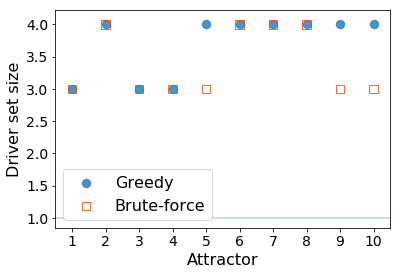

In [23]:
#graph comparison to brute-force
prev_order=[5,3,0,6,8,1,4,9,2,7] #just used to keep order of attractors the same that is used in the paper
yvalues=[len(drivers[x]) for x in prev_order]
yvalues_bf=[len(bf_drivers[x]) for x in prev_order]

plt.hlines(1.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],yvalues,label='Greedy',alpha=0.8,s=70)
plt.scatter([i for i in range(10)],yvalues_bf,label='Brute-force',alpha=0.8,marker='s',facecolors='none',edgecolors='orangered',s=70)
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)],range(1,11),fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Driver set size",fontsize=16)
plt.xlabel("Attractor",fontsize=16)
#plt.title("Size of Approximate \n and Actual Driver Sets",y=1.05,fontsize=16)
plt.legend(fontsize=16)